In [4]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached spacy-3.5.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
  Using cached preshed-3.0.8-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (128 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.4-py3-none-any.whl (11 kB)
  Using cached pydantic-1.10.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached pathy-0.10.1-py3-none-any.whl (48 kB)
  Using cached murmurhash-1.0.9-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (21 kB)
     |████████████████████████████████| 922 kB 9.6 MB/s eta 0:00:01
  Using cached wasabi-1.1.1-py3-none-any.whl (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached cymem-2.0.7-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached srsly-2.4.6-cp39-cp39-manyl

In [33]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict 
import spacy
import en_core_web_sm

In [6]:
raw = pd.read_csv('ted_talks_en.csv')
#raw

In [7]:
arr = raw['topics'].to_numpy()
keywords = defaultdict(int)
for i, inner in enumerate(arr):
    x = inner.split("'")
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            keywords[tag.lower()] += 1

In [8]:
most_common_keywords = sorted(list(keywords.keys()), key=lambda keyword: keywords[keyword])[::-1]
occurences = [keywords[keyword] for keyword in most_common_keywords]
#list(zip(most_common_keywords, occurences))

(array([380.,  39.,  16.,  10.,   4.,   6.,   1.,   0.,   0.,   2.]),
 array([  1., 100., 199., 298., 397., 496., 595., 694., 793., 892., 991.]),
 <BarContainer object of 10 artists>)

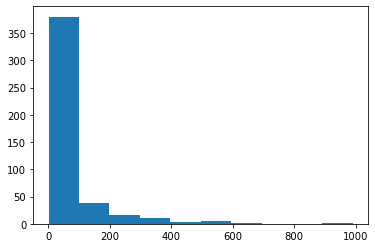

In [9]:
plt.hist(occurences)

In [10]:
cutoff = 80
y = filter(lambda x: x >= cutoff, occurences)
print(f"Amount of topics with occurences >= 80 : {len(list(y))}")

Amount of topics with occurences >= 80 : 103


In [11]:
def convert_topics(topic):
    x = topic.split("'")
    tags = []
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            tags.append(tag.lower())
    return tags

def correct_dataframe_topics_column(df):
    df = df.copy()
    topics_listed_column = df['topics'].apply(convert_topics)
    df['topics'] = topics_listed_column
    return df

corrected_topics = correct_dataframe_topics_column(raw)
#corrected_topics

In [12]:
"""
Topics of focus:
STEM - Science, Technology, Engineering, Math(Mathematics), Psychology, Physics, Biotech, AI, Cognitive Science
Culture - Culture, Society, Community
Business - Business, Economics
Social Change - social change/activism
History - History/Politics
"""
topic_to_group = defaultdict(lambda: 'not-relevant')
stem = ["science", "technology", "engineering", "math", "mathematics", "psychology", "physics", "biotech", "ai", "cognitive science"]
culture = ["culture", "society", "community"]
business = ["business", "economics"]
activism = ['social change', 'activism']
history = ['history', 'politics']
categories = [ ['stem'] + stem, ['culture'] + culture, ['business'] + business,
              ['activism'] + activism, ['history'] + history]

for category in categories:
    cat = None
    for i, topic in enumerate(category):
        if i == 0:
            cat = topic
            continue
        topic_to_group[topic] = cat

In [13]:
def group_topics(topic_list):
    grouped = set()
    for topic in topic_list:
        grouped.add(topic_to_group[topic])
    if len(grouped) > 1 and 'not-relevant' in grouped:
        grouped.remove('not-relevant')
    return grouped

def group_df_topics(df):
    df = df.copy()
    df['topics'] = df['topics'].apply(group_topics)
    return df

grouped_topics = group_df_topics(corrected_topics)
#grouped_topics

In [40]:
def one_hot_encode(df: pd.DataFrame, verbose=False):
    """
    expects df to have a columns ['words'] which contains a dictionary for each entry,
    this dictionary has all the unique words in this row's transcript as keys, and their values
    correspond the amount of time that word appears in the transcript. This creates 
    """
    word_dicts = df['words'].to_numpy()
    total_dict = defaultdict(int)
    total_count = 0
    for word_dict in word_dicts:
        for word in word_dict.keys():
            total_dict[word] += word_dict[word]
            total_count += word_dict[word]
    unique_count = len(list(total_dict.keys()))
    if verbose: 
        print("Amount of unique words: {:,}".format(unique_count), 
             "\nTotal word count: {:,}".format(total_count))
    
    word_to_onehot_location = {}
    for i, word in list(total_dict.keys()):
        word_to_onehot_location[word] = i
        
    new_col = []
    for i, row in enumerate(word_dicts):
        new_entry = np.zeros(unique_count, dtype=int)
        for word in row:
            new_entry[word_to_onehot_location[word]] = 1
        new_col.append(new_entry)
    
    new_df = df.copy()
    new_df['one-hot'] = new_col
    return new_df

In [30]:
list(unique_words.keys())

['Thank',
 'you',
 'so',
 'much,',
 'Chris.',
 'And',
 "it's",
 'truly',
 'a',
 'great',
 'honor',
 'to',
 'have',
 'the',
 'opportunity',
 'come',
 'this',
 'stage',
 'twice;',
 "I'm",
 'extremely',
 'grateful.',
 'I',
 'been',
 'blown',
 'away',
 'by',
 'conference,',
 'and',
 'want',
 'thank',
 'all',
 'of',
 'for',
 'many',
 'nice',
 'comments',
 'about',
 'what',
 'had',
 'say',
 'other',
 'night.',
 'that',
 'sincerely,',
 'partly',
 'because',
 '(Mock',
 'sob)',
 'need',
 'that.',
 '(Laughter)',
 'Put',
 'yourselves',
 'in',
 'my',
 'position.',
 'flew',
 'on',
 'Air',
 'Force',
 'Two',
 'eight',
 'years.',
 'Now',
 'take',
 'off',
 'shoes',
 'or',
 'boots',
 'get',
 'an',
 'airplane!',
 '(Applause)',
 "I'll",
 'tell',
 'one',
 'quick',
 'story',
 'illustrate',
 "that's",
 'like',
 'me.',
 "It's",
 'true',
 '—',
 'every',
 'bit',
 'is',
 'true.',
 'Soon',
 'after',
 'Tipper',
 'left',
 'White',
 'House',
 'we',
 'were',
 'driving',
 'from',
 'our',
 'home',
 'Nashville',
 'littl

In [32]:
x = 'abc...edf'
x.replace('.', '')

'abcedf'

In [39]:
pd.DataFrame.copy?

In [15]:
nlp = en_core_web_sm.load()

In [16]:
doc = nlp(grouped_topics.iloc[0].transcript)

In [72]:
doc

array([[-1.4706371 ,  0.21765131, -1.0314393 , ...,  1.4120553 ,
        -0.944253  ,  0.50613815],
       [-0.16434939,  0.82951665, -0.6400423 , ..., -0.08375989,
        -0.1077116 , -0.34314856],
       [ 1.3233514 , -0.01322406,  0.2967692 , ...,  1.2514224 ,
        -1.7730263 , -0.17876387],
       ...,
       [-0.20854652, -1.1892142 , -0.16210335, ..., -0.37219468,
        -0.31842452,  0.71036816],
       [-0.76609504, -0.22358406, -1.0391988 , ..., -0.0962096 ,
         1.8497169 ,  1.5730871 ],
       [-1.1381158 , -0.25188053, -0.5198487 , ..., -0.23793721,
         0.19479394, -1.4996935 ]], dtype=float32)

In [23]:
str.remove

Object `str.remove` not found.
